In [72]:
options(repr.plot.width  = 15, repr.plot.height = 10)

# Libraries

In [1]:
#install.packages("gbm")
#install.packages("xgboost")

Installing package into ‘/home/creyesp/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/creyesp/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



In [65]:
# Helper packages
library(dplyr)    # for general data wrangling needs

# Modeling packages
library(caret)
library(gbm)      # for original implementation of regular and stochastic GBMs
library(h2o)      # for a java-based implementation of GBM variants
library(xgboost)  # for fitting extreme gradient boosting
library(rpart)

library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Load data

In [3]:
ames <- AmesHousing::make_ames()

response <- "Sale_Price"
predictors <- setdiff(colnames(ames), response)

# Split Dataset

In [4]:
set.seed(123)
index_train <- createDataPartition(ames$Sale_Price, p = 0.8, 
                               list = FALSE, )
index_train  <- as.vector(index_train)

house_train <- ames[index_train, ]
house_test  <- ames[-index_train, ]

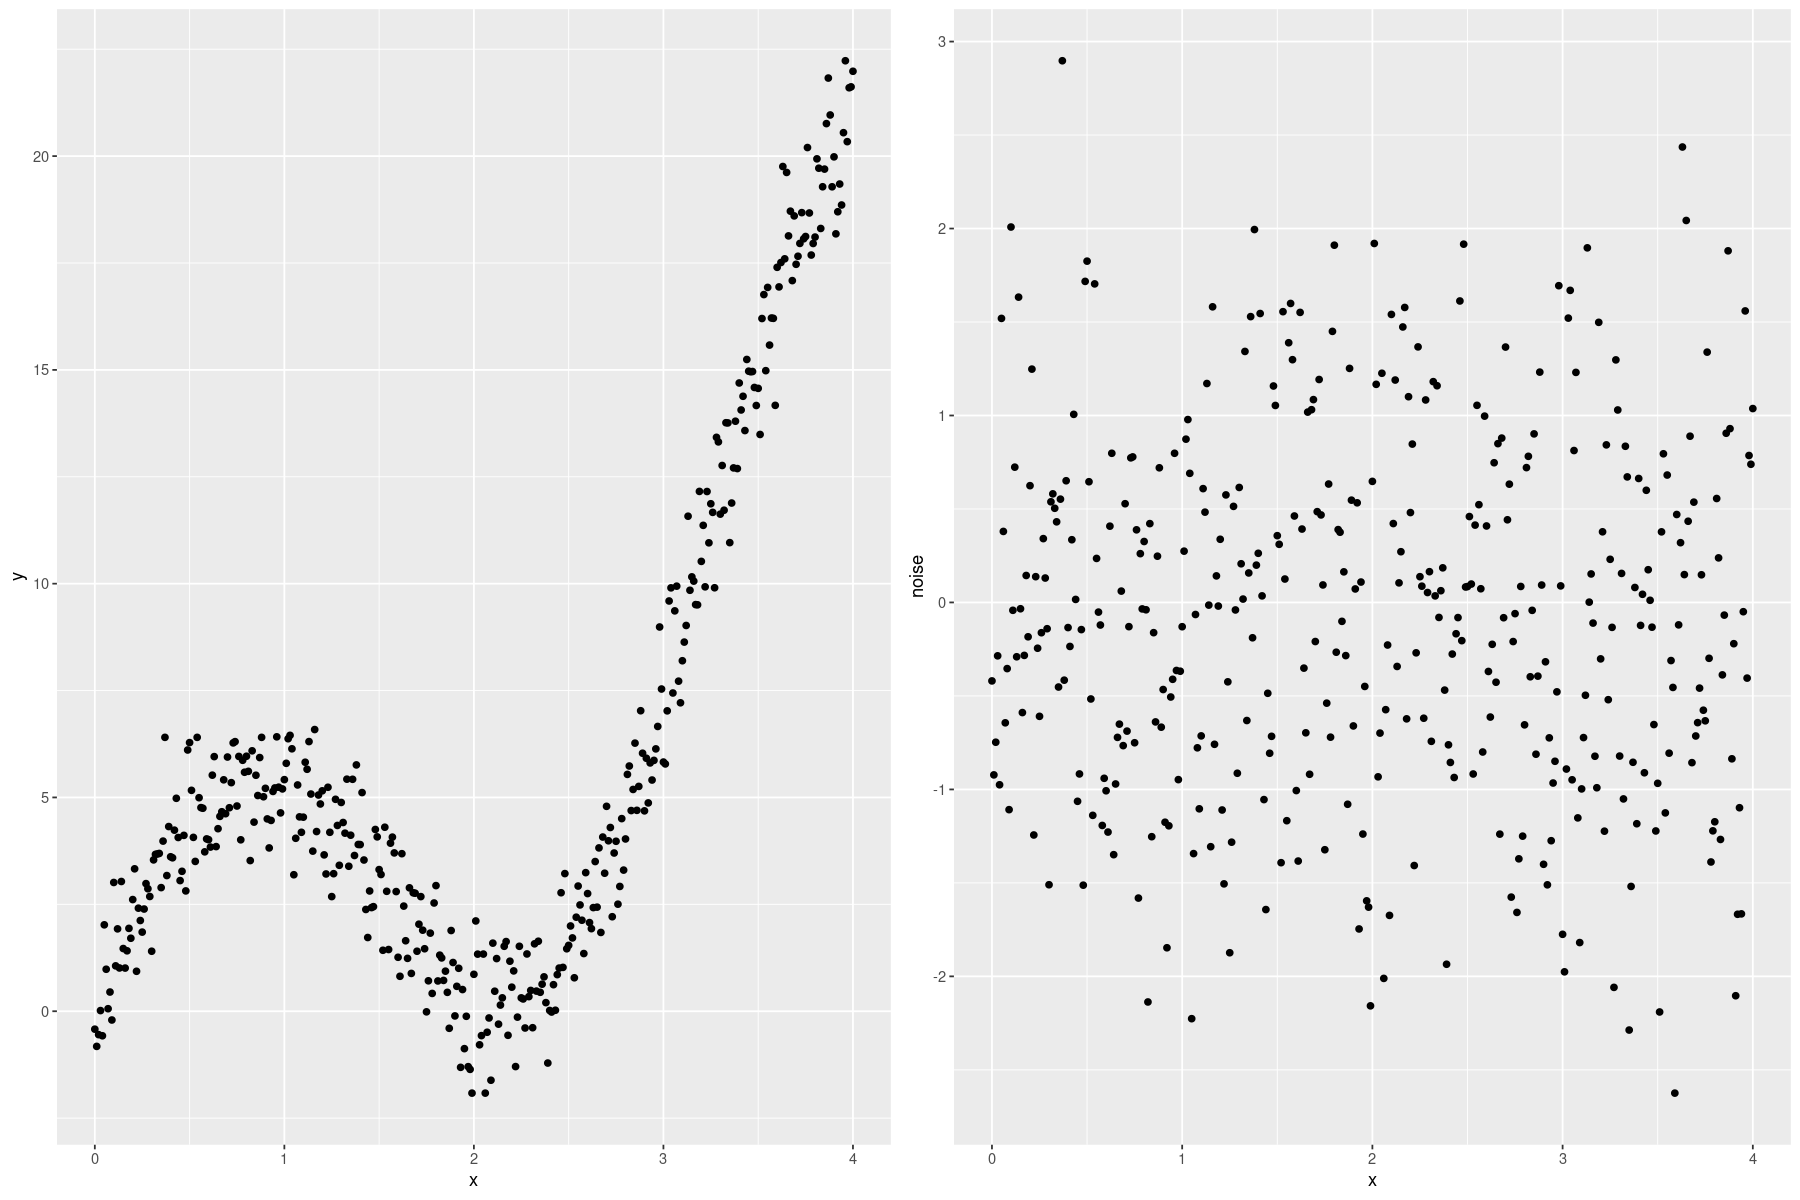

In [122]:
x <- seq(0, 4, 0.01)
noise <- rnorm(length(x))
data_fake <- data.frame(
    x = x,
    y = x**2 + 5*sin(x*2) + noise,
    noise = noise
)
p1 <- data_fake %>% ggplot(aes(x, y)) + geom_point()
p2 <- data_fake %>% ggplot(aes(x, noise)) + geom_point()
grid.arrange(p1,p2, nrow=1)

Warning message:
“Removed 74 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”


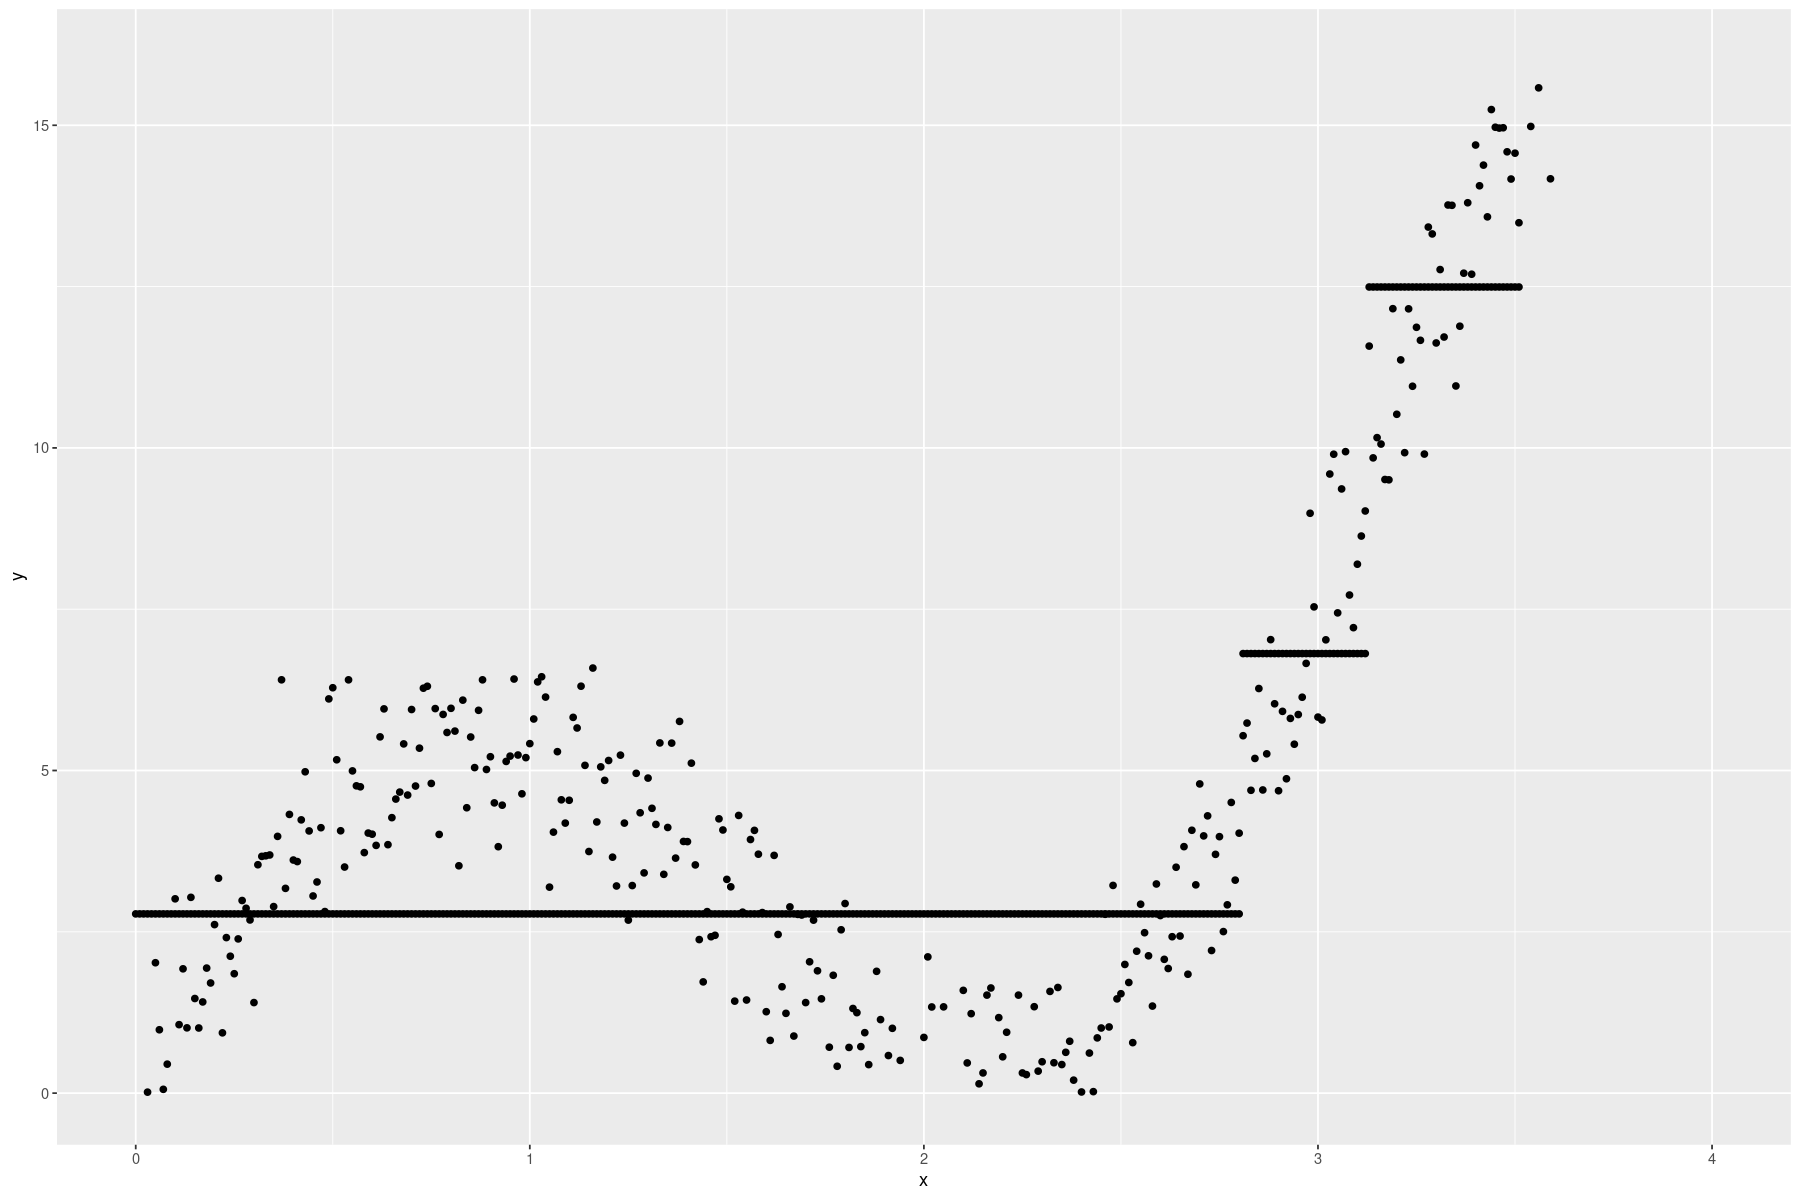

In [123]:
max_depth = 2
weak_learner1 = rpart(y ~ x, data = data_fake, maxdepth=max_depth)

data_fake$pred1 <- predict(weak_learner1, data_fake)
data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point() +
        geom_point(aes(x, pred1)) +
        xlim(0,4) +
        ylim(0,16)

In [124]:
weak_learner2 = rpart((y-pred1) ~ x, data = data_fake, maxdepth=1)
data_fake$pred2 <- predict(weak_learner2, data_fake)

unique(data_fake$pred1)
unique(data_fake$pred2)

NULL

[1]  1.1295607 -0.7421494

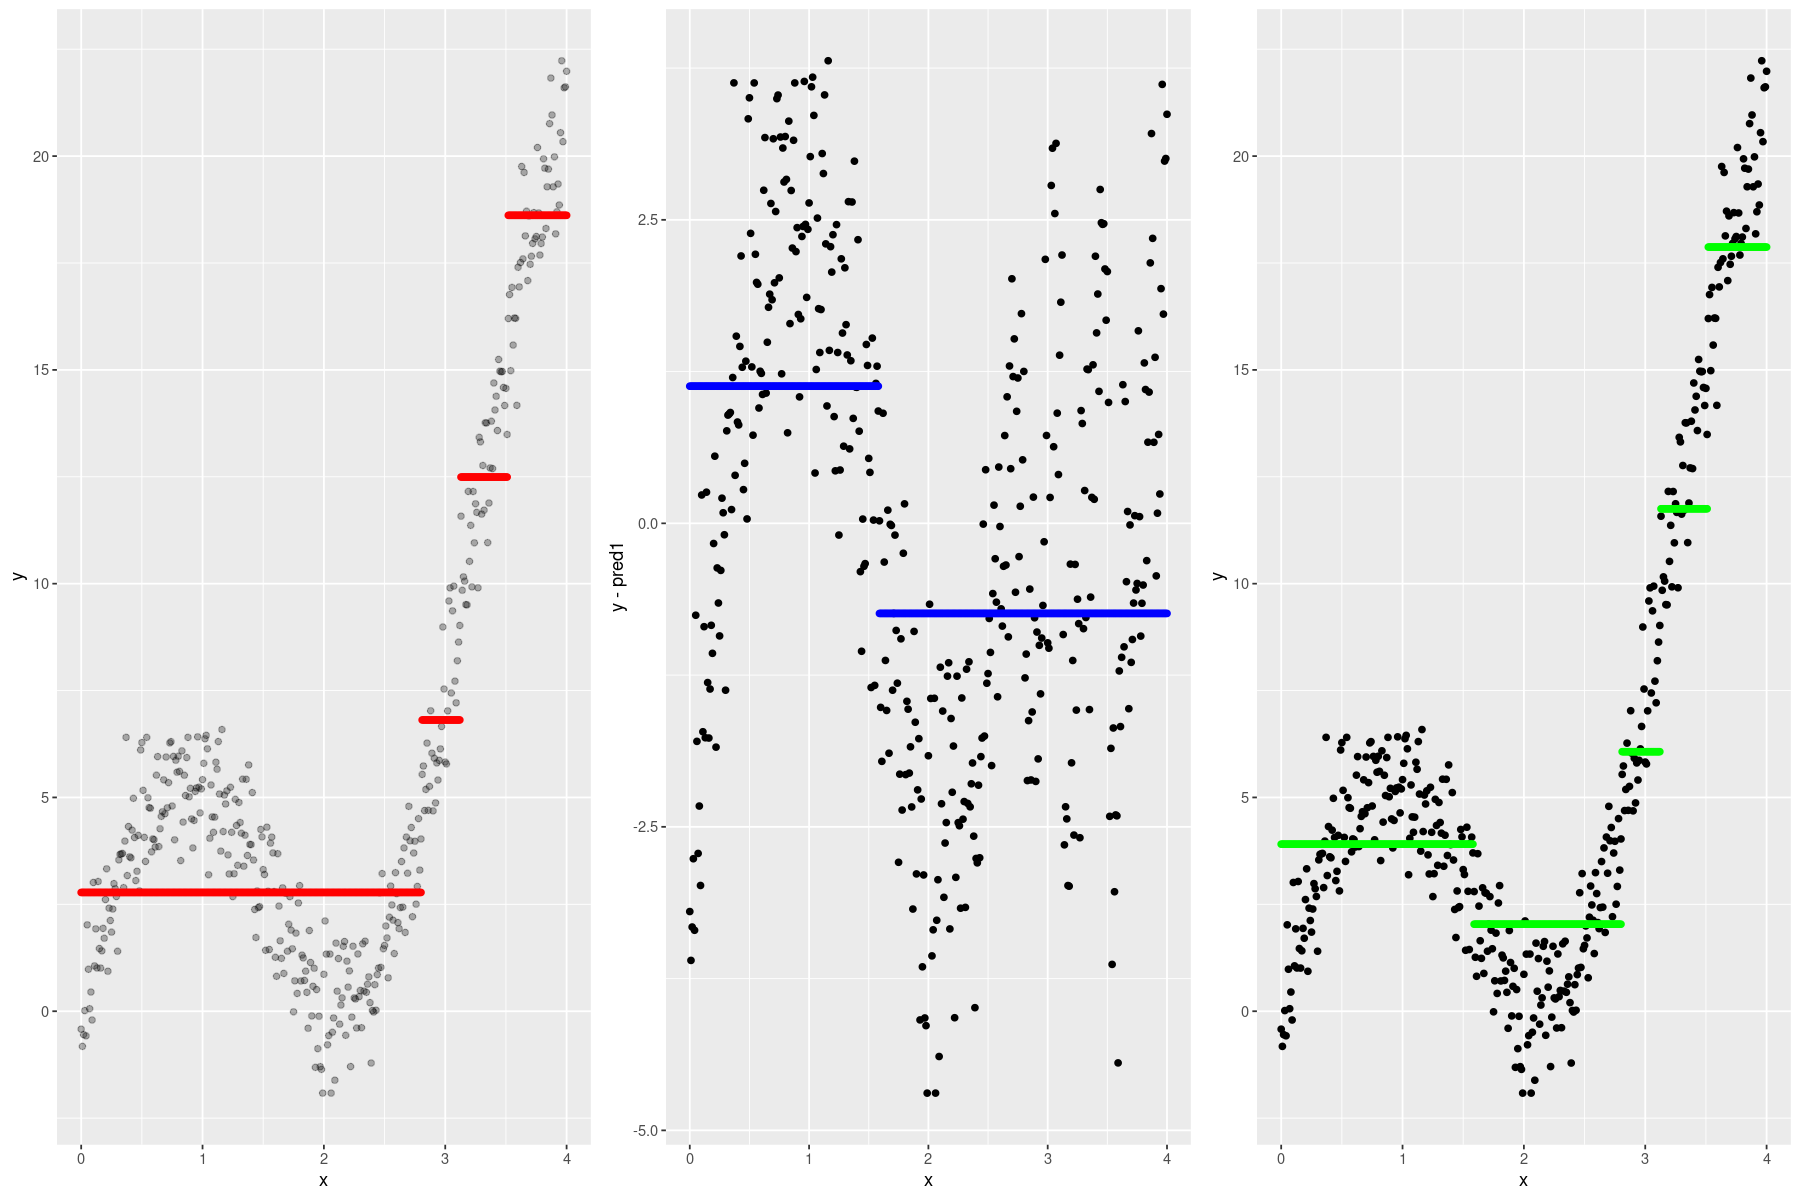

In [125]:
p1 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.3) +
        geom_point(aes(x, pred1), color='red')
        #geom_point(aes(x, (pred2)), color = 'blue') 
        
p2 <- data_fake %>% 
    ggplot(aes(x, y - pred1)) +
        geom_point() +
        #geom_point(aes(x, (pred + pred2)), color = 'green') + 
        #geom_point(aes(x, pred), color='red') +
        geom_point(aes(x, (pred2)), color = 'blue') 

p3 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point() +
        geom_point(aes(x, (pred1 + pred2)), color = 'green')
        #geom_point(aes(x, pred), color='red') +
        #geom_point(aes(x, (pred2)), color = 'blue') 


grid.arrange(p1, p2, p3, nrow = 1)

In [126]:
weak_learner3 = rpart((y - pred2 - pred1) ~ x, data = data_fake, maxdepth=max_depth)

data_fake$pred3 <- predict(weak_learner3, data_fake)

unique(data_fake$pred1)
unique(data_fake$pred2)
unique(data_fake$pred3)

NULL

[1]  1.1295607 -0.7421494

[1] -3.81159265 -1.85187334  0.08944035  2.28505713

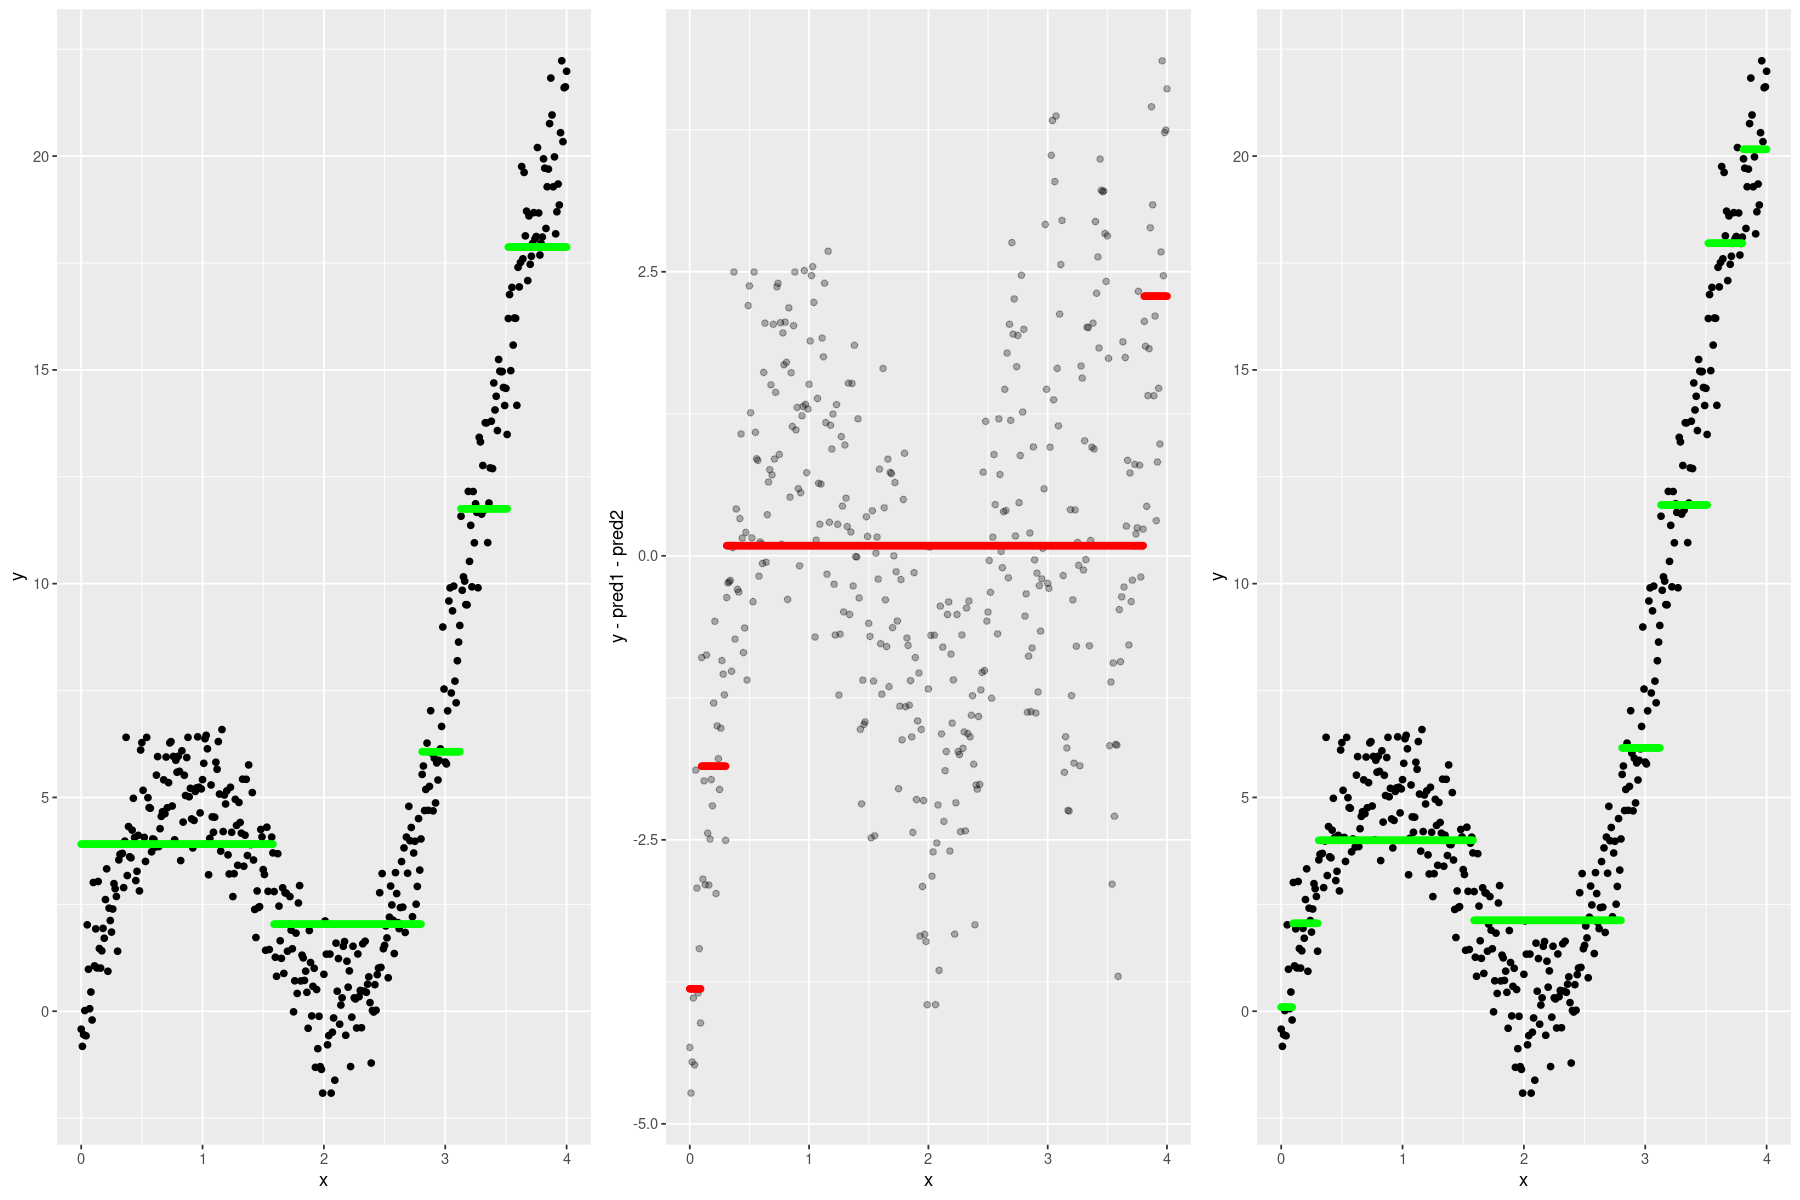

In [127]:
p1 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point() +
        geom_point(aes(x, (pred1 + pred2)), color = 'green')

p2 <- data_fake %>% 
    ggplot(aes(x, y - pred1 - pred2)) +
        geom_point(alpha=0.3) +
        geom_point(aes(x, pred3), color='red')
        #geom_point(aes(x, (pred2)), color = 'blue') 
        
p3 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point() +
        geom_point(aes(x, (pred1 + pred2 + pred3)), color = 'green')


grid.arrange(p1, p2, p3, nrow = 1)

In [128]:
weak_learner4 = rpart((y - pred3 - pred2 - pred1) ~ x, data = data_fake, maxdepth=max_depth)

data_fake$pred4 <- predict(weak_learner4, data_fake)

unique(data_fake$pred1)
unique(data_fake$pred2)
unique(data_fake$pred3)
unique(data_fake$pred4)

NULL

[1]  1.1295607 -0.7421494

[1] -3.81159265 -1.85187334  0.08944035  2.28505713

[1] -0.0583961  0.9088039 -1.3349093  0.3688594

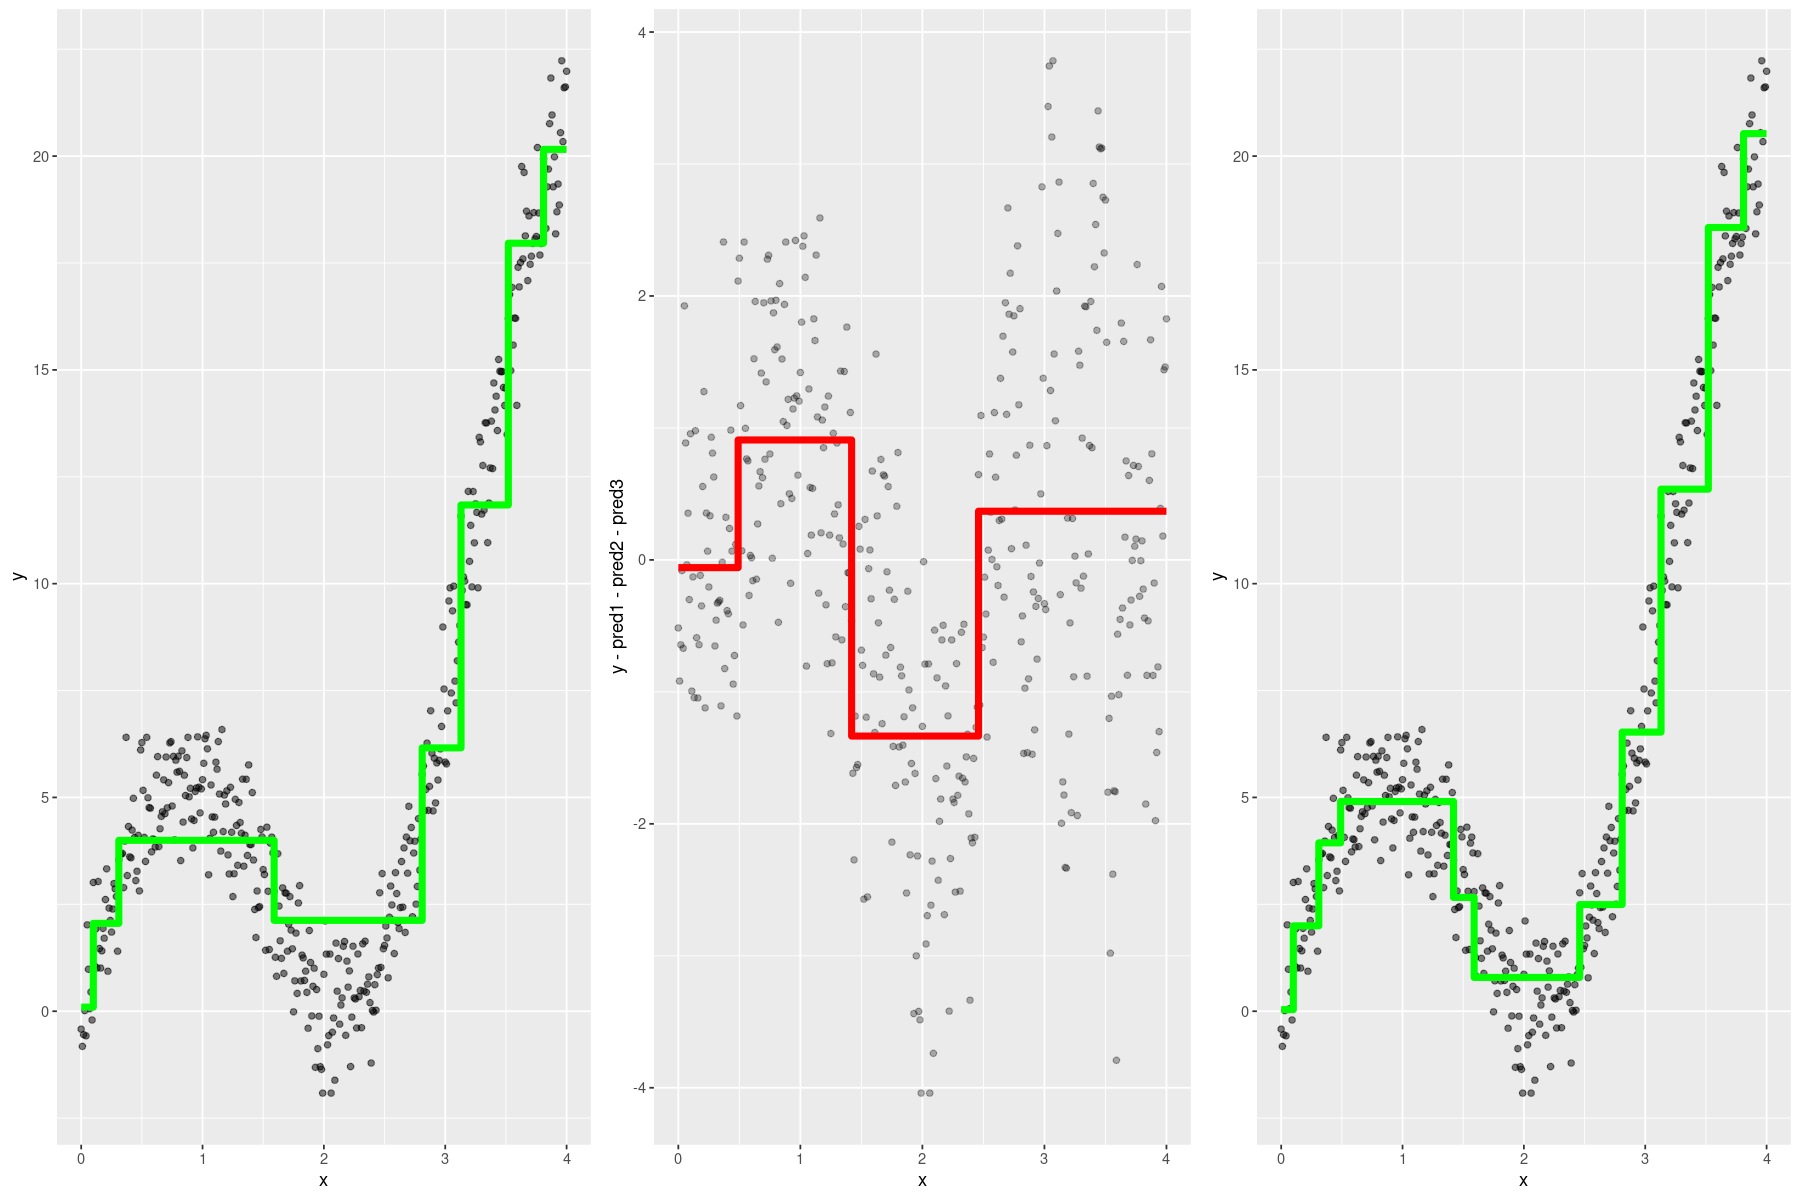

In [135]:
p1 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, (pred1 + pred2 + pred3)), color = 'green', size=2)

p2 <- data_fake %>% 
    ggplot(aes(x, y - pred1 - pred2 - pred3)) +
        geom_point(alpha=0.3) +
        geom_step(aes(x, pred4), color='red', size=2)
        #geom_point(aes(x, (pred2)), color = 'blue') 
        
p3 <- data_fake %>% 
    ggplot(aes(x, y)) +
        geom_point(alpha=0.5) +
        geom_step(aes(x, (pred1 + pred2 + pred3 + pred4)), color = 'green', size=2)


grid.arrange(p1, p2, p3, nrow = 1)

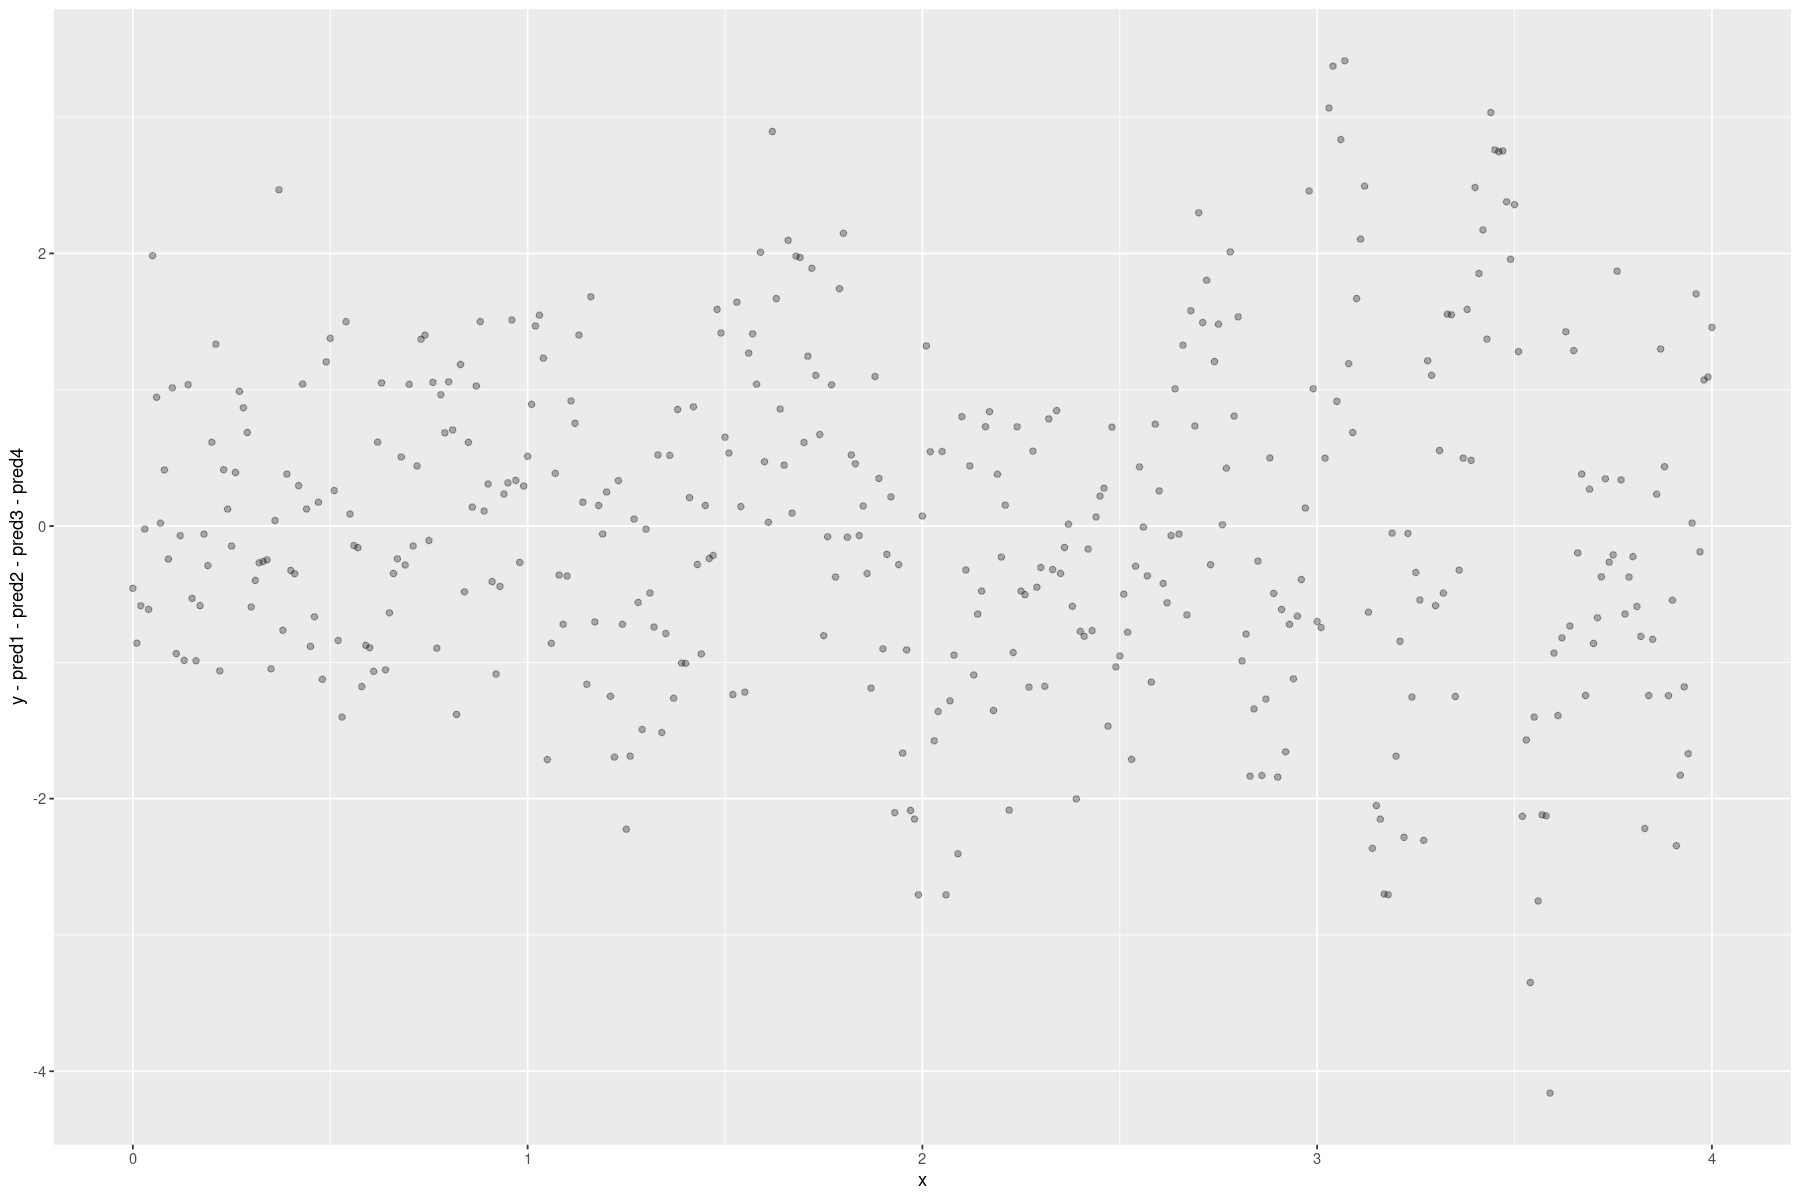

In [137]:
data_fake %>% 
    ggplot(aes(x, y - pred1 - pred2 - pred3 -pred4)) +
        geom_point(alpha=0.3)

# Modeling
## Basic GBM

**Hyperparameters**
LA version simple de GBM tiene 2 tipos de hiper-parametros:
   * boosting
   * especificos de los arboles

**Hiper-parametros de Boosting**
* **Numero de arboles**: el numero total de arboles en la secuencia. A diferencia de Bagging y RF donde el numero de arboles raramente puede generar overfitting, en boosting el hecho de la dependencia con el error del arbol anterior lo hace propenso a hacer overfittig, en general este numero puede variar en dependencia de los otros hiper-pármetros.
* **Learning rate (shrinkage)**: determina la contribucion de cada arbon en el resultado final  y controla la velocidad con la que el algoritmo desciende. Este valor va entre $[0, 1]$ y valores tipicos van entre $0.001$ - $0.3$. Valores mas pequeños hacen mas robusto a caracteristicas especificas de cada arbol, permitiendo generalizaar bien. Sin embargo valores pequeños pueden llevar a no encontrar el punto optimo y quedar en un minimo local. Generalmente valores mas pequeños logran un performance mejor pero requiere de un numero mayor de arboles en la secuencia.

**Hiper-parametros propios de cada arbol**

* **Profundidad del arbol**: Controla el la profundida maxima de cada arbol. Los valores tipicos van entre 3-8 pero no es raro ver arboles con profundad 1. Valore bajos son computacionalmente eficiente pero requiren de mas arboles en toral. Sin embargo valores mas grandes permiten capturar interacciones entre las features pero lo hace propenso a hacer overfitting.
* **Numero minimo de observacioens en un nodo**: controla la complejidad del arbon. Dado que los arboles tienden a ser poco profundos tiende a tener poco efecto. Valore tipicos van entre 5-15. Valores grandes pueden ayudar a prevenir relaciones muy especificas entre variables (overfitting) pero para los casos de dataset desbalanceados valores pequeños pueden ayudar a detectar los casos de la clase minoritaria.

The default settings in gbm include a learning rate (shrinkage) of 0.001. This is a very small learning rate and typically requires a large number of trees to sufficiently minimize the loss function. However, gbm uses a default number of trees of 100, which is rarely sufficient. Consequently, we start with a learning rate of 0.1 and increase the number of trees to train. The default depth of each tree (interaction.depth) is 1, which means we are ensembling a bunch of decision stumps (i.e., we are not able to capture any interaction effects). For the Ames housing data set, we increase the tree depth to 3 and use the default value for minimum number of observations required in the trees terminal nodes (n.minobsinnode). Lastly, we set cv.folds = 10 to perform a 10-fold CV.

In [138]:
# run a basic GBM model
set.seed(123)  # for reproducibility
ames_gbm1 <- gbm(
  formula = Sale_Price ~ .,
  data = house_train,
  distribution = "gaussian",  # SSE loss function
  n.trees = 5000,  # default = 100
  shrinkage = 0.1,  # default = 0.1
  interaction.depth = 3,
  n.minobsinnode = 10,
  cv.folds = 10
)

# find index for number trees with minimum CV error
best <- which.min(ames_gbm1$cv.error)

# get MSE and compute RMSE
sqrt(ames_gbm1$cv.error[best])
## [1] 23240.38

[1] 22342.89

[1] 823

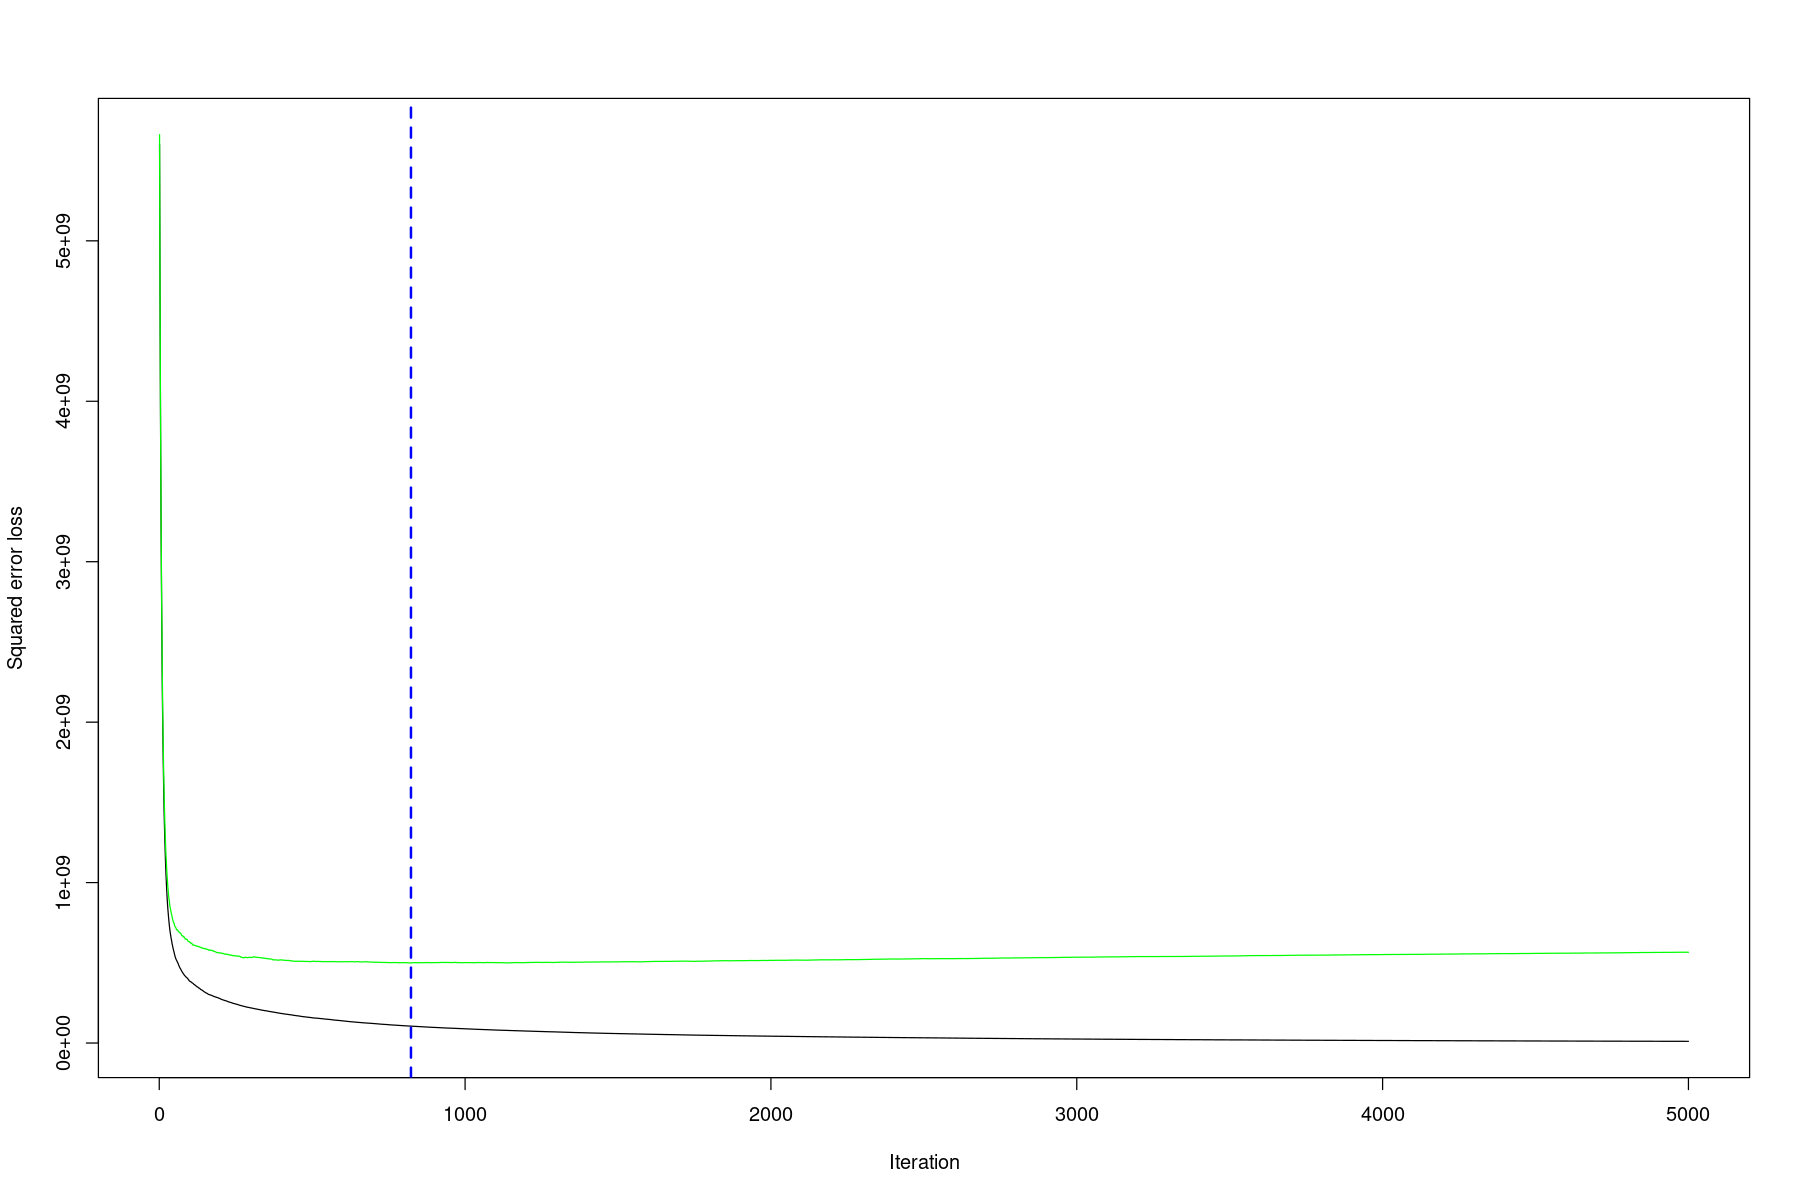

In [139]:
# plot error curve
gbm.perf(ames_gbm1, method = "cv")